
&emsp;

# 时序建模思路：模拟体重变化

ChatGPT: <https://chatgpt.com/share/681a4ce7-41d8-8005-85c4-7bf9facd992a>

无论任何模型都是对现实的简化，而这种简化的核心在于抓住事物的本质特征，然后使用合适的数学语言来描述它。

本讲会展示多种时序建模的思路，尝试刻画体重变化的规律。

大家最容易想到的就是线性模型，假设一个人的体重会随着时间的推移而逐渐增加，此时模型可以设定如下：

$$y_t = \beta_0 + \beta_1 t + \epsilon_t$$

这个模型的缺陷很明显：它假设体重变化是线性的，那么，如果 $\beta_1$ 是正数，体重就会随着时间的推移而不断增加；如果 $\beta_1$ 是负数，体重就会随着时间的推移而不断减少。

然而，现实中，很多人都有「身材管理」意识：通过调节饮食和锻炼，将自己的体重控制在一个合理的范围内。根据这个观察，我们可以设定一个具有「均值回复」特征的模型，此处的均值就是「目标体重」。例如，可以将模型设定如下：

$$y_t = \mu + \beta_1 (y_{t-1} - \mu) + \epsilon_t$$

这个模型的含义是，$t$ 时点的体重由三部分构成：(1) 目标体重 $\mu$；(2) 体重的调整 $\beta_1 (y_{t-1} - \mu)$；(3) 随机因素 $\varepsilon_{t}$。

然而，现实中，想要将体重控制在一个合理的范围内，并非易事，除了要有意志力和自制力，还需要合理安排饮食和锻炼，而这些都是有成本的，即「调整成本」。基于这一观察，可以考虑使用部分调整模型来刻画体重的变化：

$$y_t - y_{t-1} = \lambda (y_t^* - y_{t-1}) + \epsilon_t$$



## $AR(p)$ 模型

在时间序列分析中，$AR(p)$ 模型是最基本的模型之一。它假设当前值与过去 $p$ 个时刻的值存在线性关系。一般形式为：

$$
X_t = \phi_1 X_{t-1} + phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \epsilon_t \tag{1}
$$

其中，$\phi_1, \phi_2, ..., \phi_p$ 是模型参数，$\epsilon_t$ 是白噪声项。

#### $AR(1)$ 模型
当 $p=1$ 时，$AR(1)$ 模型为：

$$
X_t = \phi_1 X_{t-1} + \epsilon_t \tag{2}
$$

虽然看起来很简单，但 $AR(1)$ 模型在时间序列分析中非常重要，因为它可以捕捉到数据的自相关性。从模型设定形式上来看，它具有递推的特征，当前值仅与前一个值相关。

具体而言，(2) 式在 $t-1$ 时刻可以表示为：

$$
X_{t-1} = \phi_1 X_{t-2} + \epsilon_{t-1} \tag{3}
$$

将 (3) 式代入 (2) 式中，我们可以得到：

$$
X_t = \phi_1 (\phi_1 X_{t-2} + \epsilon_{t-1}) + \epsilon_t = \phi_1^2 X_{t-2} + \phi_1 \epsilon_{t-1} + \epsilon_t \tag{4}
$$

将 (4) 式继续递推下去，我们可以得到：

$$
X_t = \phi_1^t X_0 + \sum_{i=0}^{t-1} \phi_1^i \epsilon_{t-i} \tag{5}
$$

由 (5) 式可知，$X_t$ 由初始值 $X_0$ 和过去的随机扰动项 $\epsilon_{t-i}$ 线性组合而成。


举个例子：若 $X_0$ 表示某人 20 岁时的体重，取 $t = 10$，则 $X_{10}$ 表示该人 30 岁时的体重。假设 $X_0 = 60 kg$，$\phi_1 = 0.9$，则 (5) 式的含义是：

- 该人 30 岁时的体重 $X_{10}$，由其 20 岁时的体重 $X_0$ 与过去 10 年中的随机扰动项 $\varepsilon_{t-i}$（如饮食习惯、运动频率、作息变化、疾病史等）线性加权而成。
- 由于 $\phi_1 = 0.9$，而 $\phi_1^{10} = 0.9^{10} \approx 0.35$，说明 20 岁时的初始体重对 30 岁时体重的影响仍然存在，但已显著减弱。体重的变化更多地取决于过去 10 年逐年积累的生活方式等随机因素。
- 模型还体现出“记忆衰减”效应：越接近当前年份的扰动项，其影响越大。例如，$\varepsilon_9$ 的系数为 $\phi_1^1 = 0.9$，$\varepsilon_8$ 的系数为 $\phi_1^2 = 0.81$，$\varepsilon_7$ 的系数为 $\phi_1^3 \approx 0.729$，依此类推，扰动项的影响呈指数递减。

### $AR(1)$ 过程的平稳性
$AR(1)$ 过程的平稳性是指时间序列的均值、方差和自协方差不随时间变化。对于 $AR(1)$ 模型，平稳性条件为：
$$|\phi_1|<1$$

下面，我们来模拟生成几组 $AR(1)$ 过程的数据。

请思考如下几个问题：
- $AR(1)$ 模型能刻画一个人的体重变化吗？
- 不同的 $\phi_1$ 对数据生成有何影响？
- 模拟过程中，假设 $\epsilon_t \sim (0, \sigma^2)$，参数 $\sigma$ 的取值对数据生成有何影响？
- 如何修改这个模型才能更好地刻画一个人的体重变化？

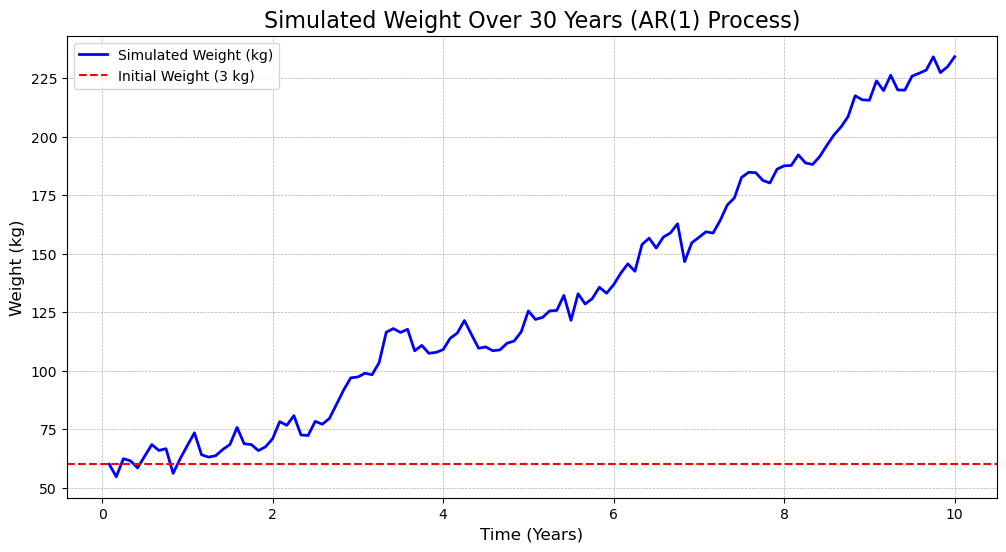

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
phi_1 = 0.99  # AR(1) 系数
sigma = 5  # 随机扰动项的标准差

X_0 = 60      # 初始体重 (kg)
n_years = 10 # 模拟 10 年
n_steps = n_years * 12  # 每年 12 个月

# 随机扰动项 (白噪声)
np.random.seed(1234)  # 固定随机种子以便复现
epsilon = np.random.normal(loc=0, scale=sigma, size=n_steps)

# 模拟 AR(1) 过程
X = np.zeros(n_steps)
X[0] = X_0
for t in range(1, n_steps):
    X[t] = phi_1 * X[t-1] + epsilon[t]

# 绘图
time = np.arange(1, n_steps + 1) / 12  # 时间轴 (以年为单位)
plt.figure(figsize=(12, 6))
plt.plot(time, X, label="Simulated Weight (kg)", color="blue", linewidth=2)
plt.axhline(y=X_0, color="red", linestyle="--", label="Initial Weight (3 kg)")
plt.title("Simulated Weight Over 30 Years (AR(1) Process)", fontsize=16)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Weight (kg)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


分析：
- $AR(1)$ 过程的期望值是常数，

## 带时间趋势项的 $AR(1)$ 模型
- $AR(1)$ 过程的方差是常数，且与 $\phi_1$ 无关
- $AR(1)$ 过程的自协方差是常数，且与 $\phi_1$ 无关

简单的 $AR(1)$ 模型无法刻画一个人的体重变化，因为它的均值和方差都是常数，且自协方差也是常数。
- 体重变化是一个非平稳的过程，均值和方差都随时间变化。
- 体重变化受多种因素影响，如饮食、运动、生活习惯等，不能仅用一个参数来描述。
- 体重变化具有一定的趋势性，如随着年龄增长，体重可能会增加或减少。

因此，我们需要引入时间趋势项来改进模型，基本模型设定形式如下：

$$X_t = \phi_1 X_{t-1} + \beta t + \epsilon_t \tag{6}$$

其中，$\beta$ 是时间趋势项的系数，$t$ 是时间变量。

(6) 式中，$\beta t$ 表示随着时间的推移，体重会有一个线性变化趋势。
- 当 $\beta > 0$ 时，表示体重随时间增加；
- 当 $\beta < 0$ 时，表示体重随时间减少；
- 当 $\beta = 0$ 时，表示体重没有明显的线性变化趋势。

- 该模型仍然具有递推的特征，当前值与前一个值相关，但同时考虑了时间趋势项的影响。
- 该模型仍然具有记忆衰减效应，当前值与前一个值的关系更强，随着时间的推移，影响逐渐减弱。



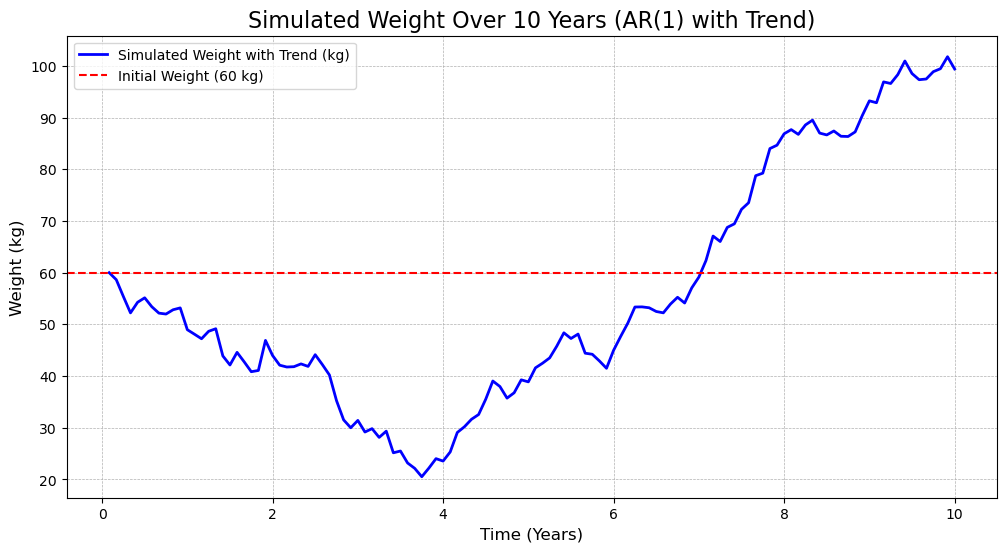

In [23]:
# 带有时间趋势项的 AR(1) 模型 (每年 12 个月)

# 参数设置
phi_1 = 0.96  # AR(1) 系数
sigma = 2  # 随机扰动项的标准差
X_0 = 60      # 初始体重 (kg)
n_years = 10  # 模拟 10 年
n_steps = n_years * 12  # 每年 12 个月
t = np.arange(1, n_steps + 1) / 12  # 时间轴 (以年为单位)
beta = 0.5    # 时间趋势项的系数

# 随机扰动项 (白噪声)
np.random.seed(12345)  # 固定随机种子以便复现
epsilon = np.random.normal(loc=0, scale=sigma, size=n_steps)

# 模拟带时间趋势项的 AR(1) 过程
X = np.zeros(n_steps)
X[0] = X_0
for i in range(1, n_steps):
    X[i] = phi_1 * X[i-1] + beta * t[i] + epsilon[i]

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(t, X, label="Simulated Weight with Trend (kg)", color="blue", linewidth=2)
plt.axhline(y=X_0, color="red", linestyle="--", label=f"Initial Weight ({X_0} kg)")
plt.title(f"Simulated Weight Over {n_years} Years (AR(1) with Trend)", fontsize=16)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Weight (kg)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


你的代码确实在数学上是一个标准的 AR(1) 过程模拟，但将其用于模拟“**体重**”这一现实变量时，会出现明显不合理的结果，比如长期内可能体重变得极大或极小，甚至负数。根本原因在于：

* AR(1) 是线性过程，**没有任何边界或长期均值约束**，不能自然模拟体重这种具有生理限制、趋势和波动特征的变量；
* 模拟过程中初始值为 3kg，这可能适合婴儿，但无法解释成人体重发展过程；
* 扰动项是对称的正态分布，容易导致极端情况。

---

# 更合理的模拟方式

## 1. **引入趋势项 + 均值回复项（趋势 + OU过程）**

现实中，体重会随着年龄增长逐渐上升，然后趋于稳定，有轻微波动。这可以用如下模型：

$$
W_t = \mu + \theta (W_{t-1} - \mu) + \varepsilon_t
$$

其中：

- $\mu$ 是目标体重水平（如 70kg）；
- $\theta$ 控制恢复速度（$0 < \theta < 1$）；
- $\varepsilon_t \sim N(0, \sigma^2)$

这称为 **Ornstein–Uhlenbeck (OU)** 过程的离散版本。



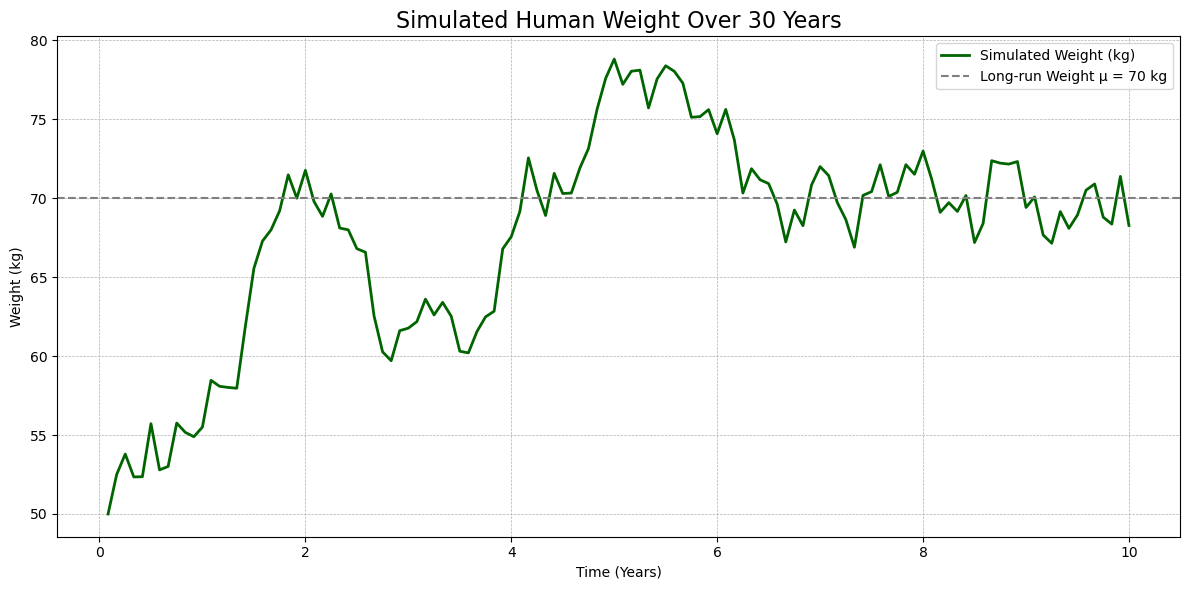

In [25]:
# 改进的模拟代码（成年人体重演化）

import numpy as np
import matplotlib.pyplot as plt

# 设置参数
mu = 70          # 长期均衡体重 (kg)
theta = 0.95     # 回复速度 (0<theta<1，越小回复越快)
sigma = 1.5      # 扰动项标准差
W_0 = 50         # 初始体重 (kg)
n_years = 10
n_steps = n_years * 12

# 白噪声扰动项
np.random.seed(123)
epsilon = np.random.normal(0, sigma, n_steps)

# 模拟 OU 过程
W = np.zeros(n_steps)
W[0] = W_0
for t in range(1, n_steps):
    W[t] = mu + theta * (W[t-1] - mu) + epsilon[t]

# 绘图
time = np.arange(1, n_steps + 1) / 12
plt.figure(figsize=(12, 6))
plt.plot(time, W, label="Simulated Weight (kg)", color="darkgreen", linewidth=2)
plt.axhline(mu, color="gray", linestyle="--", label=f"Long-run Weight μ = {mu} kg")
plt.title("Simulated Human Weight Over 30 Years", fontsize=16)
plt.xlabel("Time (Years)")
plt.ylabel("Weight (kg)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## 3. 进一步改进建议

* 若模拟儿童成长，可引入 **非线性增长趋势**（如 logistic 或 spline）；
* 若模拟节食、锻炼干预等，可引入 **断点** 或 **政策冲击项**；
* 若模拟个体差异，可引入 **随机效应项** 或分组参数。

### 儿童体重的 Logistic 增长模型

Logistic 函数形式如下：

$$
W_t = \frac{W_{\max}}{1 + \exp(-k(t - t_0))} + \varepsilon_t
$$

以下是你那段内容的正确公式格式修订版本，符合你指定的写作规范：

- $W_{max}$：成年期体重极限值（如 65 kg）
- $k$：增长速率（如 0.4）
- $t_0$：拐点（体重增长最快的时间点，单位为年）
- $ϵ_t$：扰动项（模拟个体差异或偶发波动）

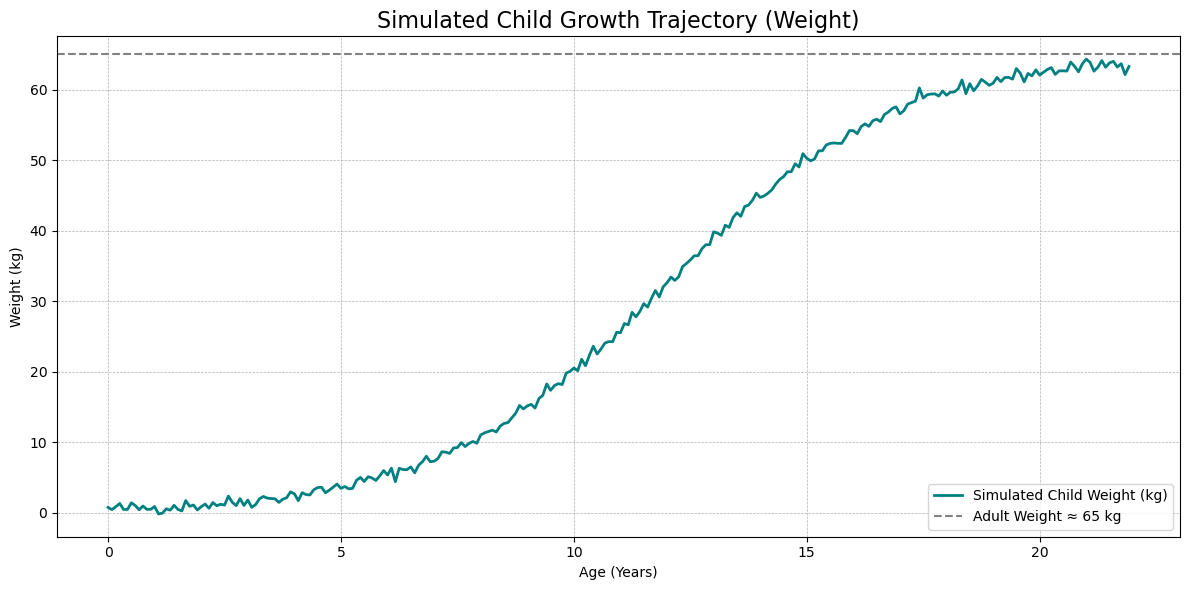

In [7]:
## 示例代码：儿童成长过程中的体重变化

import numpy as np
import matplotlib.pyplot as plt

# 模拟参数
W_max = 65     # 成年体重上限 (kg)
k = 0.4        # 增长速度
t0 = 12        # 拐点年龄（增长最快期）
sigma = 0.5    # 扰动标准差

n_years = 22
n_steps = n_years * 12
t = np.arange(n_steps) / 12  # 时间轴（以年为单位）

# 随机扰动项（模拟月度波动）
np.random.seed(42)
epsilon = np.random.normal(0, sigma, size=n_steps)

# Logistic 增长体重
W = W_max / (1 + np.exp(-k * (t - t0))) + epsilon

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(t, W, label="Simulated Child Weight (kg)", color="teal", linewidth=2)
plt.axhline(W_max, linestyle="--", color="gray", label=f"Adult Weight ≈ {W_max} kg")
plt.title("Simulated Child Growth Trajectory (Weight)", fontsize=16)
plt.xlabel("Age (Years)")
plt.ylabel("Weight (kg)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


## 结果特性说明

* 出生阶段体重较低；
* 在 $t_0$ 附近（如青春期前后）增长最快；
* 接近成年后体重趋于稳定在 $W_{max}$ 附近；
* 加入扰动项 $varepsilon_t$，体现不同孩子之间的个体差异。


## 三段式样条（piecewise spline）函数模型

以下是一个 **三段式样条（piecewise spline）函数模型**，用于模拟儿童体重的非线性增长轨迹，具有更灵活的形状变化，适合描述 **婴幼儿期缓慢增长 → 少年期快速增长 → 成年期稳定** 的过程。

模型设定：三段线性 spline（断点在 $t_1=5$ 岁和 $t_2=12$ 岁）

$$
W_t = \beta_0 + \beta_1 t + \beta_2 (t - t_1)_+ + \beta_3 (t - t_2)_+ + ϵ_t
$$

其中：

* $(x)_+ = \max(0, x)$ 表示正部函数，用于确保断点后的增长速率仅在超过断点时生效。例如，当 $t < t_1$ 时，$(t - t_1)_+ = 0$，表示断点 $t_1$ 对体重增长没有影响；当 $t \geq t_1$ 时，$(t - t_1)_+ = t - t_1$，表示断点 $t_1$ 开始对体重增长产生作用。
* $\beta_0$ 是基准体重；
* $\beta_1$ 是婴幼儿期增长速度；
* $\beta_2$ 是 5 岁以后增长速度的变动；
* $\beta_3$ 是 12 岁以后增长速度的变动；
* $ϵ_t$ 是扰动项，模拟波动与个体差异。

### 另一种解释



### 用 Indicator Function 表达模型

上述三段式样条模型可以用 **Indicator Function** 表达为：

$$
W_t = \beta_0 + \beta_1 t + \beta_2 \cdot \mathbb{1}(t > t_1) \cdot (t - t_1) + \beta_3 \cdot \mathbb{1}(t > t_2) \cdot (t - t_2) + \epsilon_t
$$

其中：

- $\mathbb{1}(\cdot)$ 是 Indicator Function，当条件为真时取值为 1，否则为 0；
- $\beta_0$ 是初始体重；
- $\beta_1$ 是婴幼儿期的增长速率；
- $\beta_2$ 和 $\beta_3$ 分别表示在断点 $t_1$ 和 $t_2$ 之后的增长速率变化；
- $\epsilon_t$ 是随机扰动项，模拟个体差异或偶发波动。

### 模型解释

1. **分段增长**：
    - 在 $t \leq t_1$ 时，$W_t = \beta_0 + \beta_1 t + \epsilon_t$，表示婴幼儿期的线性增长；
    - 在 $t_1 < t \leq t_2$ 时，$W_t = \beta_0 + \beta_1 t + \beta_2 (t - t_1) + \epsilon_t$，表示少年期增长速率的变化；
    - 在 $t > t_2$ 时，$W_t = \beta_0 + \beta_1 t + \beta_2 (t - t_1) + \beta_3 (t - t_2) + \epsilon_t$，表示成年期增长速率的进一步变化。

2. **灵活性**：
    - 通过引入断点 $t_1$ 和 $t_2$，模型能够捕捉体重增长的非线性特征；
    - 不同阶段的增长速率可以通过 $\beta_1, \beta_2, \beta_3$ 灵活调整。

3. **现实意义**：
    - 该模型适合描述儿童体重的增长轨迹，能够反映婴幼儿期缓慢增长、少年期快速增长、成年期趋于稳定的过程。

### 边际效应

边际效应是指在给定的自变量水平下，因变量对自变量的变化率。对于三段式样条模型，可以通过求导来计算边际效应 $\frac{\partial{y}}{\partial{t}}$：
- 在 $t \leq t_1$ 时，边际效应为 $\frac{\partial{y}}{\partial{t}} \mid_{t \leq t_1}= \beta_1$；
  
- 在 $t_1 < t \leq t_2$ 时，边际效应为 $\frac{\partial{y}}{\partial{t}} \mid_{t_1 < t \leq t_2}  = \beta_1 + \beta_2$；
- 在 $t > t_2$ 时，边际效应为 $\frac{\partial{y}}{\partial{t}} \mid _{t > t_2} = \beta_1 + \beta_2 + \beta_3$。

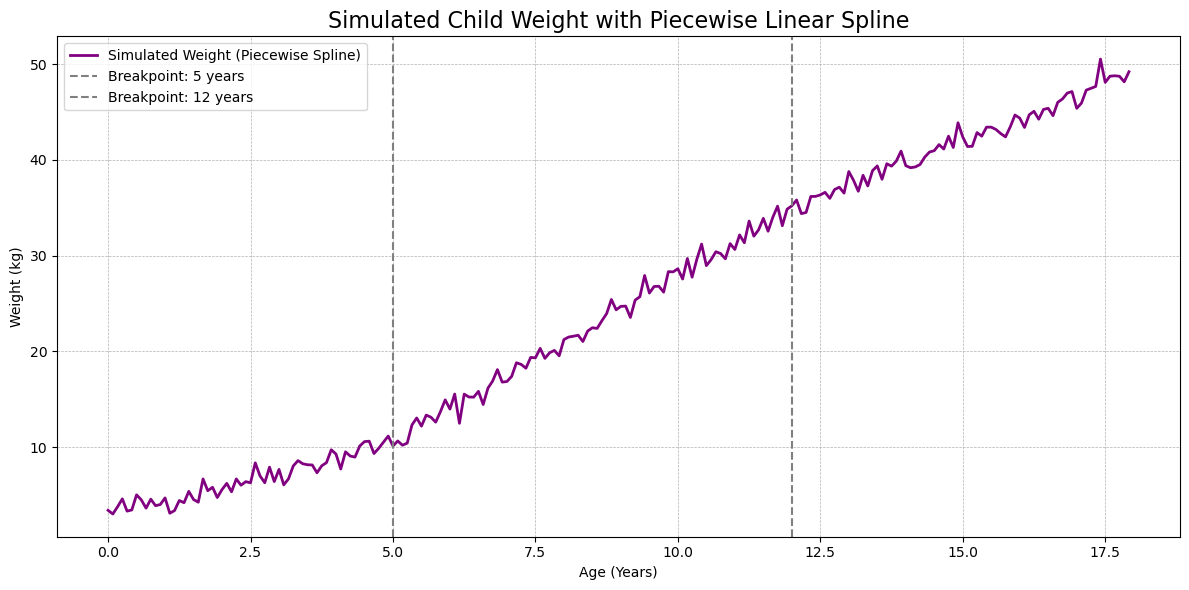

In [ ]:
## Python 实现代码

import numpy as np
import matplotlib.pyplot as plt

# 时间设定
n_years = 18
n_steps = n_years * 12
t = np.arange(n_steps) / 12  # 年龄（以年为单位）

# 断点设定
t1 = 5
t2 = 12

# Spline 变量
def positive_part(x):
    return np.maximum(0, x)

s1 = positive_part(t - t1)
s2 = positive_part(t - t2)

# 模拟参数
beta_0 = 3      # 初始体重（kg）
beta_1 = 1.5    # 0-5 岁期间增长速率
beta_2 = 2.0    # 5-12 岁之后的增长变化
beta_3 = -1.2   # 12 岁之后的增长放缓
sigma = 0.8     # 扰动标准差

# 随机扰动项
np.random.seed(42)
epsilon = np.random.normal(0, sigma, size=n_steps)

# 构建体重轨迹
W = beta_0 + beta_1 * t + beta_2 * s1 + beta_3 * s2 + epsilon

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(t, W, label="Simulated Weight (Piecewise Spline)", color="purple", linewidth=2)
plt.axvline(x=t1, linestyle="--", color="gray", label=f"Breakpoint: {t1} years")
plt.axvline(x=t2, linestyle="--", color="gray", label=f"Breakpoint: {t2} years")
plt.title("Simulated Child Weight with Piecewise Linear Spline", fontsize=16)
plt.xlabel("Age (Years)")
plt.ylabel("Weight (kg)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()



需要我继续输出自然样条（cubic spline）或用 `patsy` 和 `statsmodels` 等 Python 包自动拟合的版本吗？
